# Analyzing Milwaukee Police Call Data and Weather Data
### Grant Fass and Chris Hubbell

## Introduction
Across the world, there are many crimes commited every hour. One of the greatest challenges is reducing crime and maintaining safety for citizens. Part of preventing crime relies on the reporting of it by citizens. If nobody informs the police, the police are unable to act. This is why reporting crimes and incidents is so important, especially when people's lives are in danger. In Wisconsin, Milwaukee Police Department (MPD) releases data regarding all of their dispatch calls, which we have been able to get since 2016. This allows for analyzing trends of crime reporting over time as well as as it relates to other factors. In 2010, Milwaukee installed a new system for detecting gun shots called ShotSpotter, which was expanded into more neighborhoods in 2014. This system is capable of detecting when a shot is fired and where it was to a high degree of accuracy. The data consists of both ShotSpotter calls as well as Shots Fired calls. The key difference is that Shots Fired are calls from people and ShotSpotter are automatic.

## Research Questions:
- Is there a significant difference between the distribution of shots spotted over time and calls for shots fired?
- Is there a significant difference in the proportion of calls that were unable to be located for shots fired calls compared to shots spotted?
- Does the Proportion of shots spotted and fired correlate with certain dates including holidays and events?
- Does the number of calls correlate with certain weather conditions?
- ~~Is it possible to predict number of calls based on location and district?~~
- Is it possible to predict the nature of a call based on its location and district?

## Hypotheses:
- There are significantly more shots spotted than calls about shots fired.
- Significantly more shots fired calls are unable to be located than shots spotted.
- There will be significantly more shots spotted calls on July 4th, Dec. 31st, and Jan 1st than normal days.
- There will be significantly less shots fired calls on holidays than normal days.
- There are significantly more calls on days with clear weather than inclement weather.
- There are significantly more calls on days around 24 degrees than there are on days around 35 or 13 degrees.
- ~~The number of calls will be able to be predicted based on location and district.~~
- The type of call will be unable to be predicted based on location and district.

## Notes:
One of the research questions and one of the hypotheses is striked out. This is because it was not possible to come up with a good method for measuring this in time.

# Imports
These are the libraries that will be relvant for working with the dataset.

In [166]:
%matplotlib inline
import math
from statistics import mean
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import kstest
from scipy.stats import ks_2samp
from scipy.stats import chi2_contingency, chisquare
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.decomposition import TruncatedSVD

from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

sns.set(rc={"figure.figsize":(16, 8)})

# Loading the Data
This section is used to load the data and make sure that all of the features have been formatted using the correct types. This data is ready for use since it has already been cleaned in another notebook. The MPDDataCleaning notebook was used to clean the MPD (Milwaukee Police Department) dataset. The WeatherDataCleaning notebook was used to clean the weather dataset. These two datasets were then combined in the DatasetCombining notebook.

In [51]:
df = pd.read_csv('merged_data.csv')

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4027695 entries, 0 to 4027694
Data columns (total 34 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   status                 object 
 1   call_id                int64  
 2   datetime               object 
 3   isCorner               bool   
 4   primaryStreetName      object 
 5   primaryStreetSuffix    object 
 6   secondaryStreetName    object 
 7   secondaryStreetSuffix  object 
 8   shots_nature           object 
 9   top_natures            object 
 10  top_districts          object 
 11  isdaytime              bool   
 12  tempC                  int64  
 13  windspeedKmph          int64  
 14  winddirdegree          int64  
 15  weatherDesc            object 
 16  precipMM               float64
 17  humidity               int64  
 18  visibilityKm           int64  
 19  pressureMB             int64  
 20  cloudcover             int64  
 21  HeatIndexC             int64  
 22  DewPointC         

## Revising Feature Types
Calling the [`.info()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html) command shows that there are a number of features that are improperly formatted. The district, nature, status, primaryStreetName, primaryStreetSuffix, secondaryStreetName, secondaryStreetSuffix, and weatherDesc all need to become categorical features. The datetime feature needs to be changed to datetime.

In [53]:
df['status'] = df['status'].astype('category')
df['primaryStreetName'] = df['primaryStreetName'].astype('category')
df['primaryStreetSuffix'] = df['primaryStreetSuffix'].astype('category')
df['secondaryStreetName'] = df['secondaryStreetName'].astype('category')
df['secondaryStreetSuffix'] = df['secondaryStreetSuffix'].astype('category')
df['weatherDesc'] = df['weatherDesc'].astype('category')
df['datetime'] = pd.to_datetime(df['datetime'], infer_datetime_format=True)
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
df['shots_nature'] = df['shots_nature'].astype('category')
df['top_natures'] = df['top_natures'].astype('category')
df['top_districts'] = df['top_districts'].astype('category')

## Examining The Loaded Data
The data should now be in the proper types. This will be examined using the [`.head()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html), [`.info()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html), and [`.describe()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) methods.

In [54]:
df.head(5).T

,0,1,2,3,4
status,Assignment Completed,Advised/Referral,Assignment Completed,Assignment Completed,Advised
call_id,163120850,163120774,163120851,163120853,163120857
datetime,2016-11-07 09:33:52,2016-11-07 09:33:55,2016-11-07 09:34:58,2016-11-07 09:36:20,2016-11-07 09:38:10
isCorner,False,False,False,False,False
primaryStreetName,N 4TH,W BLUE MOUND,N 93RD,W LINCOLN,N 25TH
primaryStreetSuffix,ST,RD,ST,AV,ST
secondaryStreetName,None,None,None,None,None
secondaryStreetSuffix,None,None,None,None,None
shots_nature,OTHER,OTHER,OTHER,OTHER,OTHER
top_natures,FOLLOW UP,PROPERTY DAMAGE,OTHER,FOLLOW UP,TRAFFIC STOP


In [55]:
df.tail(5).T

,4027690,4027691,4027692,4027693,4027694
status,Service in Progress,Advised,To be Filed,Service in Progress,Assignment Completed
call_id,220101027,220101028,220101031,220101034,220101039
datetime,2022-01-10 15:28:31,2022-01-10 15:29:07,2022-01-10 15:32:26,2022-01-10 15:34:19,2022-01-10 15:34:59
isCorner,False,False,False,False,False
primaryStreetName,W VLIET,S 43RD,N WATER,N LOVERS LANE,N 49TH
primaryStreetSuffix,ST,ST,ST,RD,ST
secondaryStreetName,None,None,None,None,None
secondaryStreetSuffix,None,None,None,None,None
shots_nature,OTHER,OTHER,OTHER,OTHER,OTHER
top_natures,OTHER,TRAFFIC STOP,BATTERY,OTHER,OTHER


In [56]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4027695 entries, 0 to 4027694
Data columns (total 34 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   status                 4027695 non-null  category      
 1   call_id                4027695 non-null  int64         
 2   datetime               4027695 non-null  datetime64[ns]
 3   isCorner               4027695 non-null  bool          
 4   primaryStreetName      4016778 non-null  category      
 5   primaryStreetSuffix    4027695 non-null  category      
 6   secondaryStreetName    4027391 non-null  category      
 7   secondaryStreetSuffix  4027695 non-null  category      
 8   shots_nature           4027695 non-null  category      
 9   top_natures            4027695 non-null  category      
 10  top_districts          4027695 non-null  category      
 11  isdaytime              4027695 non-null  bool          
 12  tempC                  40276

In [57]:
df.describe()

,call_id,tempC,windspeedKmph,winddirdegree,precipMM,humidity,visibilityKm,pressureMB,cloudcover,HeatIndexC,...,WindChillC,WindGustKmph,FeelsLikeC,uvIndex,year,month,week,day,hour,weekday
count,4.027695e+06,4.027695e+06,4.027695e+06,4.027695e+06,4.027695e+06,4.027695e+06,4.027695e+06,4.027695e+06,4.027695e+06,4.027695e+06,...,4.027695e+06,4.027695e+06,4.027695e+06,4.027695e+06,4.027695e+06,4.027695e+06,4.027695e+06,4.027695e+06,4.027695e+06,4.027695e+06
mean,1.891808e+08,9.332960e+00,1.396831e+01,1.978097e+02,8.068526e-02,7.252384e+01,9.280653e+00,1.016711e+03,4.627480e+01,9.741805e+00,...,7.040703e+00,2.030895e+01,7.329460e+00,2.161411e+00,2.018734e+03,6.556297e+00,2.678238e+01,1.570493e+01,1.276070e+01,2.910867e+00
std,1.459309e+07,1.099667e+01,6.506821e+00,9.301290e+01,3.459743e-01,1.560838e+01,1.861185e+00,7.728984e+00,3.620323e+01,1.150243e+01,...,1.314242e+01,9.506874e+00,1.356433e+01,1.869588e+00,1.467857e+00,3.476425e+00,1.518563e+01,8.888607e+00,6.723860e+00,1.971860e+00
min,1.630815e+08,-3.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.600000e+01,0.000000e+00,9.860000e+02,0.000000e+00,-3.000000e+01,...,-4.400000e+01,0.000000e+00,-4.400000e+01,1.000000e+00,2.016000e+03,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.732129e+08,1.000000e+00,9.000000e+00,1.260000e+02,0.000000e+00,6.100000e+01,1.000000e+01,1.012000e+03,1.100000e+01,1.000000e+00,...,-3.000000e+00,1.300000e+01,-3.000000e+00,1.000000e+00,2.017000e+03,4.000000e+00,1.400000e+01,8.000000e+00,8.000000e+00,1.000000e+00
50%,1.906707e+08,9.000000e+00,1.300000e+01,2.140000e+02,0.000000e+00,7.400000e+01,1.000000e+01,1.016000e+03,3.900000e+01,9.000000e+00,...,6.000000e+00,1.900000e+01,6.000000e+00,1.000000e+00,2.019000e+03,6.000000e+00,2.600000e+01,1.600000e+01,1.400000e+01,3.000000e+00
75%,2.016115e+08,1.900000e+01,1.800000e+01,2.760000e+02,0.000000e+00,8.500000e+01,1.000000e+01,1.021000e+03,8.300000e+01,1.900000e+01,...,1.900000e+01,2.600000e+01,1.900000e+01,3.000000e+00,2.020000e+03,1.000000e+01,4.000000e+01,2.300000e+01,1.800000e+01,5.000000e+00
max,2.201010e+08,3.500000e+01,4.700000e+01,3.600000e+02,1.630000e+01,1.000000e+02,1.000000e+01,1.048000e+03,1.000000e+02,4.100000e+01,...,3.500000e+01,7.100000e+01,4.100000e+01,9.000000e+00,2.022000e+03,1.200000e+01,5.300000e+01,3.100000e+01,2.300000e+01,6.000000e+00


### Data Description
This contains the combined data from the sets of the Milwaukee Dispatch Calls and Milwaukee Historical Weather that has been cleaned and had features engineered with descriptions and justifications in MPDDataCleaning.ipynb and WeatherDataCleaning.ipynb, respectively. The data was then merged in DatasetCombining.ipynb.

### Investigating the Shape of Data
This section looks to explore the shape of the data by generating graphs. These graphs will focus on the number of calls per some unit of time.

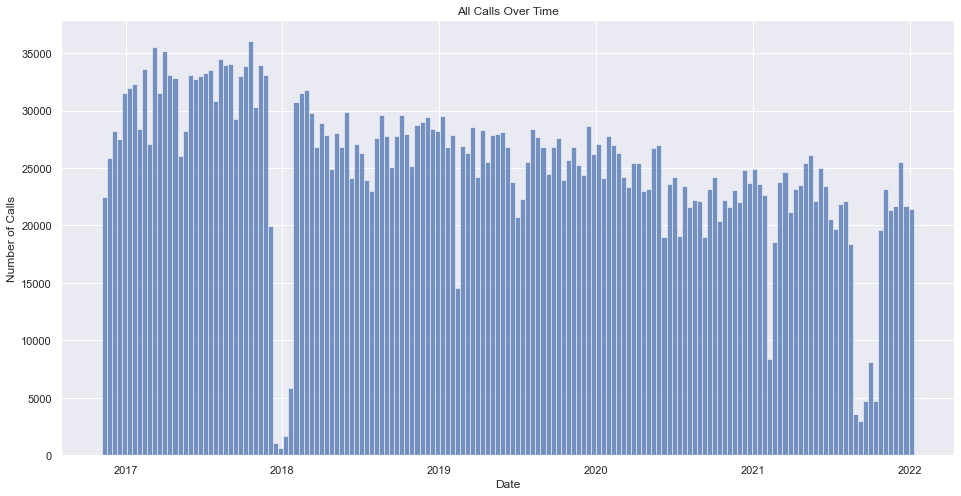

In [181]:
ax = sns.histplot(data=df, x='date')
ax.set_title('All Calls Over Time')
ax.set_ylabel('Number of Calls')
ax.set_xlabel('Date')
plt.show()

This graph shows all of the call types over time. What is interesting is that there appears to be a big gap around 2018 and smaller gaps in 2019 and 2021. There is a second big gap between 2021 and 2022 but not as bad as the 2018 gap. Another interesting observation is that it appears that overall call numbers is trending down. Looking deeper:

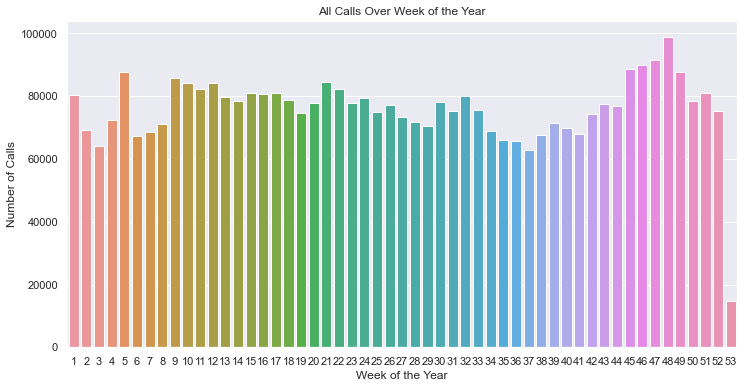

In [59]:
ax = sns.countplot(data=df, x='week')
ax.set_title('All Calls Over Week of the Year')
ax.set_ylabel('Number of Calls')
ax.set_xlabel('Week of the Year')
plt.show()

This graph shows a comparison between the number of calls recieved per week of the year. The number of calls looks to be consistent. There is one issue in that the data has 53 weeks each year. This should not be the case.

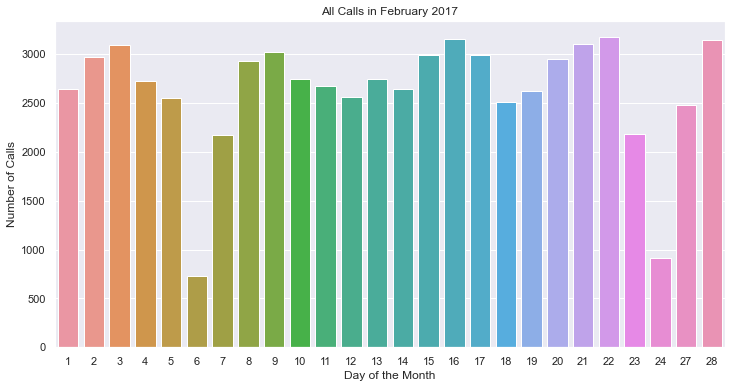

In [60]:
ax = sns.countplot(data=df[(df['year'] == 2017) & (df['month']==2)], x='day')
ax.set_title('All Calls in February 2017')
ax.set_ylabel('Number of Calls')
ax.set_xlabel('Day of the Month')
plt.show()

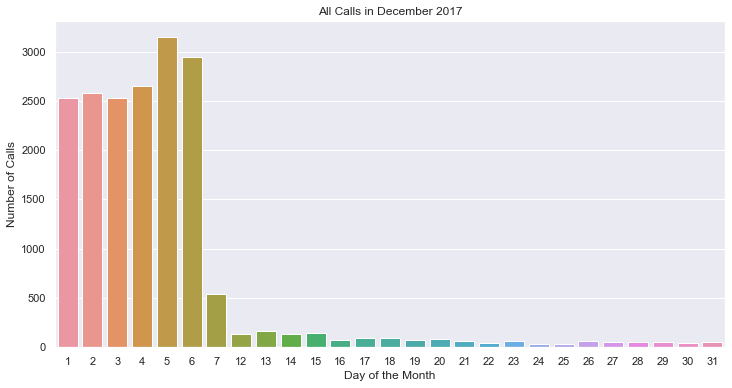

In [61]:
ax = sns.countplot(data=df[(df['year'] == 2017) & (df['month']==12)], x='day')
ax.set_title('All Calls in December 2017')
ax.set_ylabel('Number of Calls')
ax.set_xlabel('Day of the Month')
plt.show()

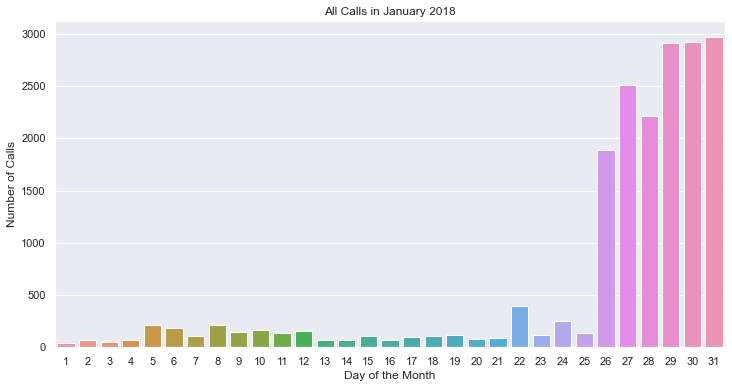

In [62]:
ax = sns.countplot(data=df[(df['year'] == 2018) & (df['month']==1)], x='day')
ax.set_title('All Calls in January 2018')
ax.set_ylabel('Number of Calls')
ax.set_xlabel('Day of the Month')
plt.show()

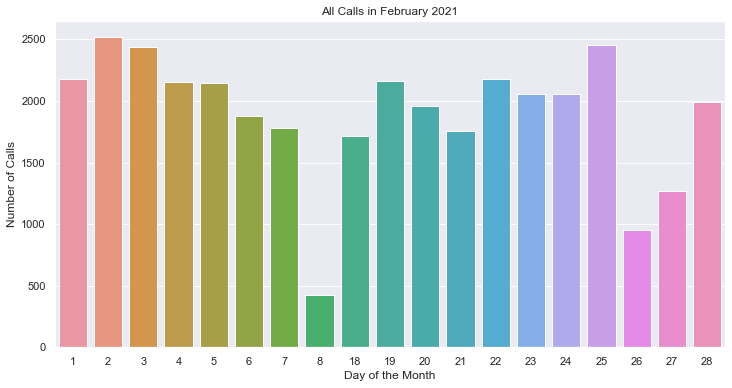

In [63]:
ax = sns.countplot(data=df[(df['year'] == 2021) & (df['month']==2)], x='day')
ax.set_title('All Calls in February 2021')
ax.set_ylabel('Number of Calls')
ax.set_xlabel('Day of the Month')
plt.show()

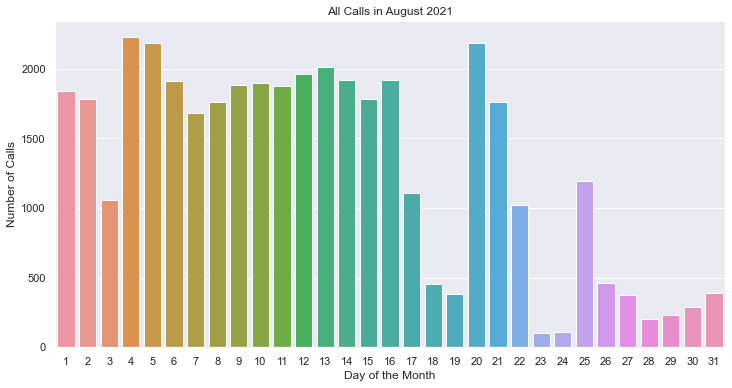

In [64]:
ax = sns.countplot(data=df[(df['year'] == 2021) & (df['month']==8)], x='day')
ax.set_title('All Calls in August 2021')
ax.set_ylabel('Number of Calls')
ax.set_xlabel('Day of the Month')
plt.show()

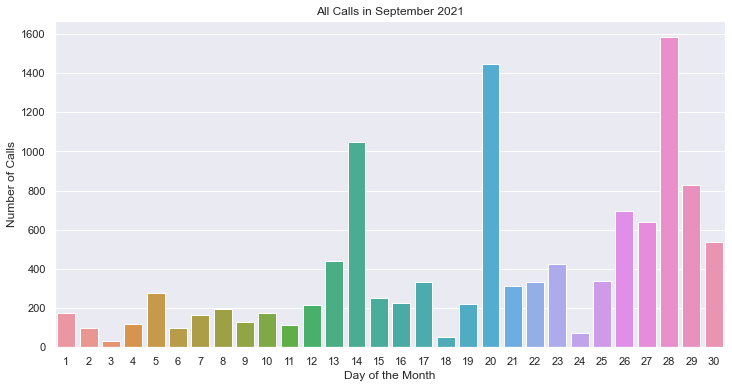

In [65]:
ax = sns.countplot(data=df[(df['year'] == 2021) & (df['month']==9)], x='day')
ax.set_title('All Calls in September 2021')
ax.set_ylabel('Number of Calls')
ax.set_xlabel('Day of the Month')
plt.show()

After speaking with the provider of the data, the reason there's significantly less data in these locations has to do with either their machines being down or the MPD's services being down. This may be recoverable with a Freedom Of Information Act (FOIA) request but that would take to long for this project. We must work with what we've got.

# Examining the Research Questions
This section will seek to examine the research questions outlined at the top of the notebook by exploring the data through the use of both graphs and statistical tests. This section will use a few possible different statistical tests based on the scenario and shape of the data. The [Kolmogorov-Smirnov test](http://www.mit.edu/~6.s085/notes/lecture5.pdf) can be used to test if two arbitrary distributions are the same. [It does not require the data being normally distributed](http://statstutor.ac.uk/resources/steps-glossary/glossary/nonparametric.html#:~:text=The%20Kolmogorov%2DSmirnov%20test%20does,Squared%20Goodness%20of%20Fit%20Test.&text=The%20Kruskal%2DWallis%20test%20is,compare%20three%20or%20more%20samples.&text=It%20is%20the%20analogue%20to,used%20in%20analysis%20of%20variance.). The [two sample t-test](https://www.jmp.com/en_us/statistics-knowledge-portal/t-test/two-sample-t-test.html) can be used to test if the means of two distributions are the same. The [Kruskal-Wallis test](https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_one-way_analysis_of_variance) can be used to determine if two samples come from the same distribution. The Kruskal-Wallis test does require that the data be normally distributed though. The [chi-squared test](https://stats.oarc.ucla.edu/spss/whatstat/what-statistical-analysis-should-i-usestatistical-analyses-using-spss/#:~:text=A%20chi%2Dsquare%20test%20is,relationship%20between%20two%20categorical%20variables.) will be used to test if there is a relationship between two categorical variables. The research questions that seek to determine if prediction is possible will be examined in a later section on building machine learning models.

## Preparation
 Some of the graphs use help from [this](https://www.statology.org/seaborn-legend-outside/) for moving the legend outside of the graph, and from [this](https://stackoverflow.com/a/60679315) for plotting multiple categories (fix legend not showing). 
 
 A filtered dataframe can be created containing only the entries for weapon crime. Extra categorical values must be removed when filtering down a categorical feature with many values (such as nature). This can be done by redefining the type as a category.

In [66]:
shots_df = df[df['top_natures'].isin(['SHOTSPOTTER', 'SHOTS FIRED'])][['top_natures', 'status', 'datetime', 'date', 'year', \
    'month', 'week', 'day', 'hour', 'weekday']].copy(deep=True)
shots_df['top_natures'] = shots_df['top_natures'].astype('object').astype('category')
shots_df['notLocated'] = shots_df['status']=='Unable to Locate Complainant'
print("Data Shape After: %s" % ((shots_df.shape), ))
shots_df.head(10).T

Data Shape After: (112712, 11)


,150,151,165,247,346,347,401,406,442,445
top_natures,SHOTSPOTTER,SHOTSPOTTER,SHOTSPOTTER,SHOTSPOTTER,SHOTS FIRED,SHOTSPOTTER,SHOTS FIRED,SHOTS FIRED,SHOTS FIRED,SHOTSPOTTER
status,Assignment Completed,Assignment Completed,To be Filed,Service in Progress,Service in Progress,Assignment Completed,Unable to Locate Complainant,Service in Progress,Unable to Locate Complainant,Assignment Completed
datetime,2016-11-07 11:12:32,2016-11-07 11:12:40,2016-11-07 11:25:18,2016-11-07 12:18:59,2016-11-07 13:18:53,2016-11-07 13:19:34,2016-11-07 14:00:56,2016-11-07 14:04:32,2016-11-07 14:35:52,2016-11-07 14:37:27
date,2016-11-07 00:00:00,2016-11-07 00:00:00,2016-11-07 00:00:00,2016-11-07 00:00:00,2016-11-07 00:00:00,2016-11-07 00:00:00,2016-11-07 00:00:00,2016-11-07 00:00:00,2016-11-07 00:00:00,2016-11-07 00:00:00
year,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016
month,11,11,11,11,11,11,11,11,11,11
week,45,45,45,45,45,45,45,45,45,45
day,7,7,7,7,7,7,7,7,7,7
hour,11,11,11,12,13,13,14,14,14,14
weekday,0,0,0,0,0,0,0,0,0,0


## Research Question 1: Is There a Significant Difference Between the Distribution of Shots Spotted Over Time and Calls for Shots Fired?
The first step in answering this research question is to graph the distributions of shots spotted and shots fired over time. These can be compared over different possible time ranges. Some of the possible time ranges for comparisons include day of the week, day of the month, week of the year, month of the year, and daily over the entire time range of the dataset. These graphs can then be looked at to predict if a dataset is normally distributed or not. The outcome of this prediction will then determine what statistical test should be used.

### Graphing Shots Spotted vs. Shots Fired Over Time

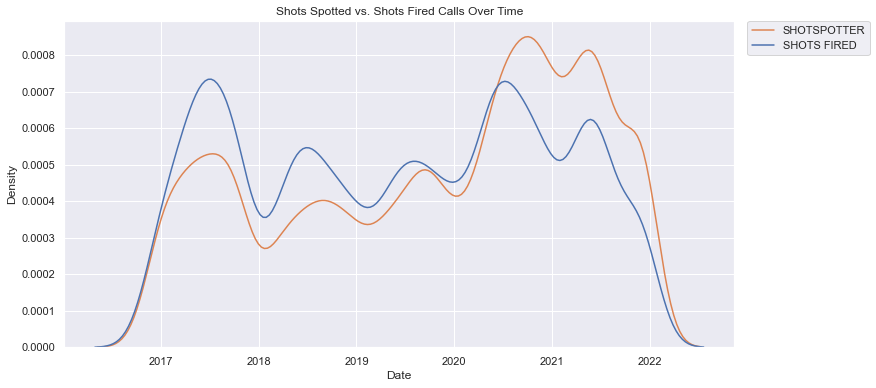

In [67]:
# plot of shots spotted vs shots fired over time
# Graph is not the best but is the most legible out of possible formats.
uses = shots_df['top_natures'].unique()
ax = plt.axes()
for use in uses:
    sns.kdeplot(x=shots_df["date"], hue=shots_df[shots_df['top_natures']==use]["top_natures"], ax=ax, common_norm=False, multiple="layer", alpha=1, label=use)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax.set_title("Shots Spotted vs. Shots Fired Calls Over Time")
ax.set_xlabel('Date')
plt.show()

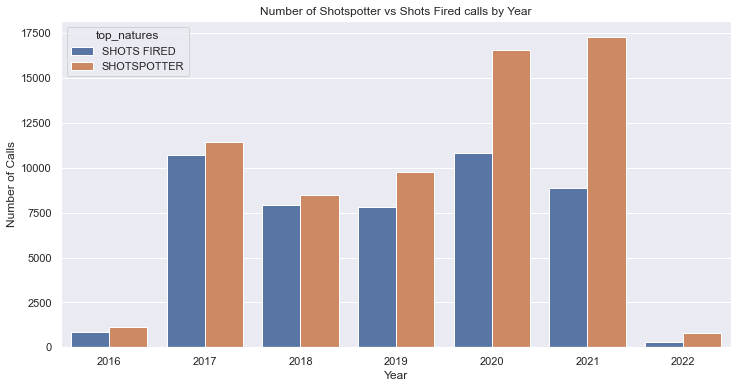

In [68]:
ax = sns.countplot(x="year", hue="top_natures", data=shots_df)
ax.set_xlabel('Year')
ax.set_ylabel('Number of Calls')
ax.set_title('Number of Shotspotter vs Shots Fired calls by Year')
plt.show()

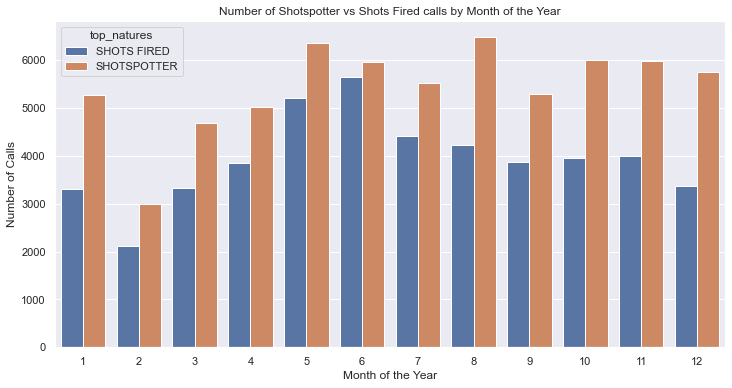

In [69]:
ax = sns.countplot(x="month", hue="top_natures", data=shots_df)
ax.set_xlabel('Month of the Year')
ax.set_ylabel('Number of Calls')
ax.set_title('Number of Shotspotter vs Shots Fired calls by Month of the Year')
plt.show()

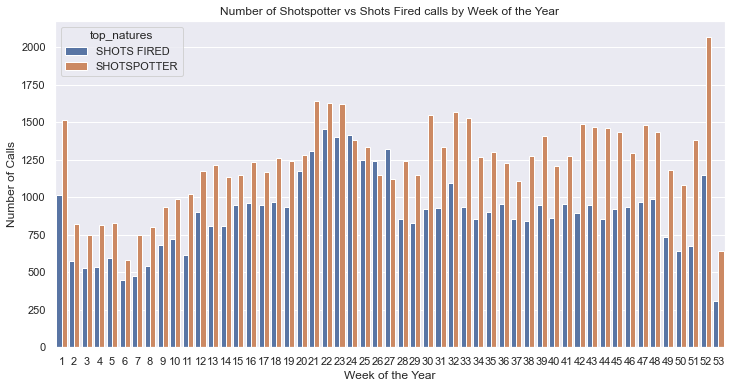

In [70]:
ax = sns.countplot(x="week", hue="top_natures", data=shots_df)
ax.set_xlabel('Week of the Year')
ax.set_ylabel('Number of Calls')
ax.set_title('Number of Shotspotter vs Shots Fired calls by Week of the Year')
plt.show()

This graph shows that there is some anomalous data since there are not 53 weeks in a year.

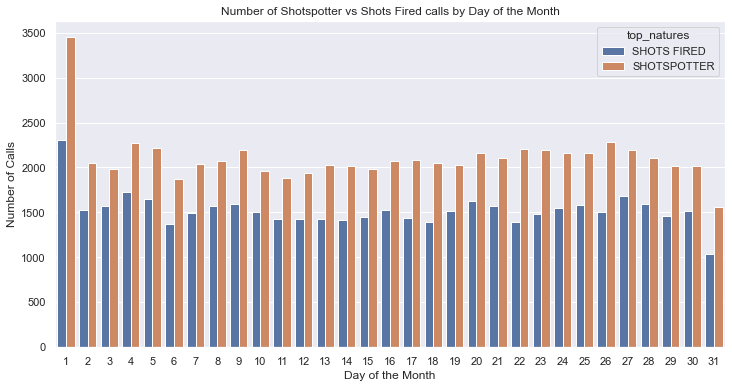

In [71]:
ax = sns.countplot(x="day", hue="top_natures", data=shots_df)
ax.set_xlabel('Day of the Month')
ax.set_ylabel('Number of Calls')
ax.set_title('Number of Shotspotter vs Shots Fired calls by Day of the Month')
plt.show()

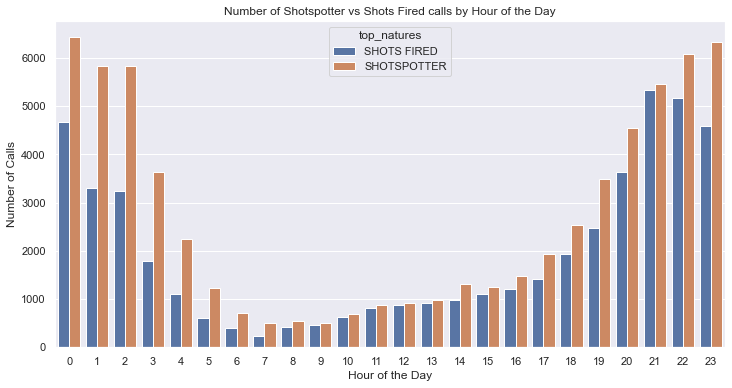

In [72]:
ax = sns.countplot(x="hour", hue="top_natures", data=shots_df)
ax.set_xlabel('Hour of the Day')
ax.set_ylabel('Number of Calls')
ax.set_title('Number of Shotspotter vs Shots Fired calls by Hour of the Day')
plt.show()

### Performing Statistical Tests to Determine if the Distributions are Simmilar.
The above graphs show that neither the distribution of shots fired or shots spotted are normal for any time increment. This means that the Kruskal-Wallis statistical test cannot be used. The [Kolmogorov-Smirnov test, from the scipy stats library,](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html) will be used to determine if the number of shots spotted and shots called are simmilar. The [two sample version](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html#scipy.stats.ks_2samp) of the test will be used. The 'two sided' mode will be used for this test. This defines the null hypothesis to be that the two distributions are identical and the alternative to be that they are not identical. Tests will be run over different time ranges.

#### Year

In [189]:
# Extract distributions to use in statistical tests
shots_fired_calls_per_time_unit = shots_df[shots_df['top_natures'] == 'SHOTS FIRED']['year'].value_counts().sort_index()
shots_spotted_calls_per_time_unit = shots_df[shots_df['top_natures'] == 'SHOTSPOTTER']['year'].value_counts().sort_index()

In [190]:
_, p = ks_2samp(shots_fired_calls_per_time_unit, shots_spotted_calls_per_time_unit, alternative='two-sided')
print('The p-value for the Kolmogorov-Smirnov test between the distributions of shots spotted and shots fired over time is: %e' % p)

The p-value for the Kolmogorov-Smirnov test between the distributions of shots spotted and shots fired over time is: 5.751748e-01


The Kolmogorov-Smirnov test reported a p-value of $5.752*10^{-1}$ when comparing the distributions of shots fired and shots spotted over the specified time range. The p-value being greater than the threshold of $1.526*10^{-6}$ means the test was not statisticaly significant. From this we reject the alternative hypothesis.

#### Month of the Year

In [191]:
# Extract distributions to use in statistical tests
shots_fired_calls_per_time_unit = shots_df[shots_df['top_natures'] == 'SHOTS FIRED']['month'].value_counts().sort_index()
shots_spotted_calls_per_time_unit = shots_df[shots_df['top_natures'] == 'SHOTSPOTTER']['month'].value_counts().sort_index()

In [192]:
_, p = ks_2samp(shots_fired_calls_per_time_unit, shots_spotted_calls_per_time_unit, alternative='two-sided')
print('The p-value for the Kolmogorov-Smirnov test between the distributions of shots spotted and shots fired over time is: %e' % p)

The p-value for the Kolmogorov-Smirnov test between the distributions of shots spotted and shots fired over time is: 1.496955e-03


The Kolmogorov-Smirnov test reported a p-value of $1.497*10^{-3}$ when comparing the distributions of shots fired and shots spotted over the specified time range. The p-value being greater than the threshold of $7.629*10^{-7}$ means the test was not statisticaly significant. From this we reject the alternative hypothesis.

#### Week of the Year

In [193]:
# Extract distributions to use in statistical tests
shots_fired_calls_per_time_unit = shots_df[shots_df['top_natures'] == 'SHOTS FIRED']['week'].value_counts().sort_index()
shots_spotted_calls_per_time_unit = shots_df[shots_df['top_natures'] == 'SHOTSPOTTER']['week'].value_counts().sort_index()

In [194]:
_, p = ks_2samp(shots_fired_calls_per_time_unit, shots_spotted_calls_per_time_unit, alternative='two-sided')
print('The p-value for the Kolmogorov-Smirnov test between the distributions of shots spotted and shots fired over time is: %e' % p)

The p-value for the Kolmogorov-Smirnov test between the distributions of shots spotted and shots fired over time is: 6.200869e-10


The Kolmogorov-Smirnov test reported a p-value of $6.200*10^{-10}$ when comparing the distributions of shots fired and shots spotted over the specified time range. The p-value being less than the threshold of $3.815*10^{-7}$ means the test was statisticaly significant. From this we reject the null hypothesis and accept the alternative. This means the distributions of shots fired and shots spotted were significantly different.

#### Day of the Month

In [195]:
# Extract distributions to use in statistical tests
shots_fired_calls_per_time_unit = shots_df[shots_df['top_natures'] == 'SHOTS FIRED']['day'].value_counts().sort_index()
shots_spotted_calls_per_time_unit = shots_df[shots_df['top_natures'] == 'SHOTSPOTTER']['day'].value_counts().sort_index()

In [196]:
_, p = ks_2samp(shots_fired_calls_per_time_unit, shots_spotted_calls_per_time_unit, alternative='two-sided')
print('The p-value for the Kolmogorov-Smirnov test between the distributions of shots spotted and shots fired over time is: %e' % p)

The p-value for the Kolmogorov-Smirnov test between the distributions of shots spotted and shots fired over time is: 8.125848e-15


The Kolmogorov-Smirnov test reported a p-value of $8.126*10^{-15}$ when comparing the distributions of shots fired and shots spotted over the specified time range. The p-value being less than the threshold of $1.907*10^{-7}$ means the test was statisticaly significant. From this we reject the null hypothesis and accept the alternative. This means the distributions of shots fired and shots spotted were significantly different.

#### Hour of the Day

In [197]:
# Extract distributions to use in statistical tests
shots_fired_calls_per_time_unit = shots_df[shots_df['top_natures'] == 'SHOTS FIRED']['hour'].value_counts().sort_index()
shots_spotted_calls_per_time_unit = shots_df[shots_df['top_natures'] == 'SHOTSPOTTER']['hour'].value_counts().sort_index()

In [198]:
_, p = ks_2samp(shots_fired_calls_per_time_unit, shots_spotted_calls_per_time_unit, alternative='two-sided')
print('The p-value for the Kolmogorov-Smirnov test between the distributions of shots spotted and shots fired over time is: %e' % p)

The p-value for the Kolmogorov-Smirnov test between the distributions of shots spotted and shots fired over time is: 4.490368e-01


The Kolmogorov-Smirnov test reported a p-value of $4.490*10^{-1}$ when comparing the distributions of shots fired and shots spotted over the specified time range. The p-value being greater than the threshold of $9.537*10^{-8}$ means the test was not statisticaly significant. From this we reject the alternative hypothesis.

### Date

In [199]:
# Extract distributions to use in statistical tests
shots_fired_calls_per_time_unit = shots_df[shots_df['top_natures'] == 'SHOTS FIRED']['date'].value_counts().sort_index()
shots_spotted_calls_per_time_unit = shots_df[shots_df['top_natures'] == 'SHOTSPOTTER']['date'].value_counts().sort_index()

In [200]:
_, p = ks_2samp(shots_fired_calls_per_time_unit, shots_spotted_calls_per_time_unit, alternative='two-sided')
print('The p-value for the Kolmogorov-Smirnov test between the distributions of shots spotted and shots fired over time is: %e' % p)

The p-value for the Kolmogorov-Smirnov test between the distributions of shots spotted and shots fired over time is: 1.213059e-41


The Kolmogorov-Smirnov test reported a p-value of $1.213*10^{-41}$ when comparing the distributions of shots fired and shots spotted over the specified time range. The p-value being less than the threshold of $4.768*10^{-8}$ means the test was statisticaly significant. From this we reject the null hypothesis and accept the alternative. This means the distributions of shots fired and shots spotted were significantly different.

### Conclusions for Research Question 1
The Kolmogorov-Smirnov test was used to compare the distributions of shots spotted vs shots fired over various time ranges.
- Year: was not significant
- Month: was not significant
- Week: was significant
- Day: was significant
- Hour: was not significant
- Date: was significant

This means that the alternative hypothesis was rejected for year, month, and hour. The alternative hypothesis was accepted for week, day, and date. This means that the distributions were not identical over the week, day and date time ranges. All of the rejected alternative hypotheses did have p-values below 0.05, however they did not pass the lowered threshold used by $\alpha$-investing.

## Research Question 2: Is There a Significant Difference in the Proportion of Calls That Were Unable to be Located for Shots Fired Calls Compared to Shots Spotted?

### Graphs

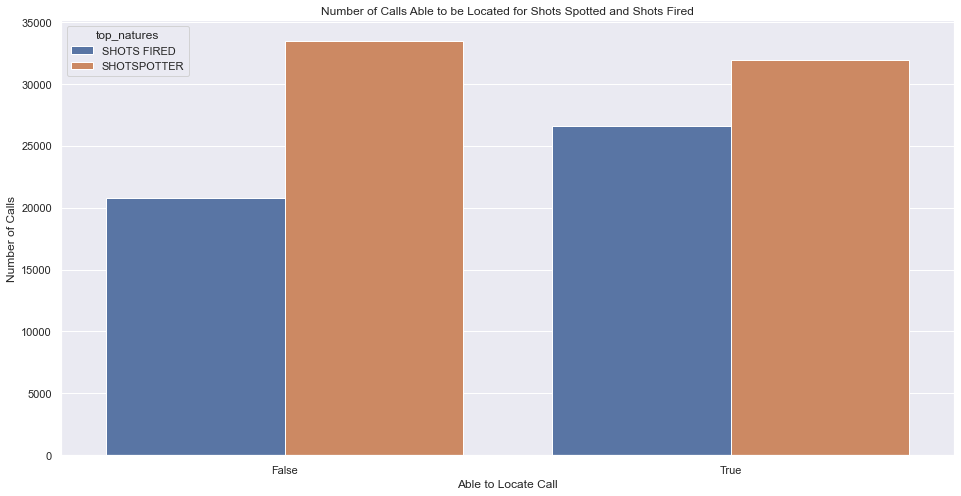

In [208]:
able_to_locate = shots_df["notLocated"].map(lambda x: not x)
ax = sns.countplot(x=able_to_locate, hue=shots_df['top_natures'])
ax.set_xlabel('Able to Locate Call')
ax.set_ylabel('Number of Calls')
ax.set_title('Number of Calls Able to be Located for Shots Spotted and Shots Fired')
plt.show()

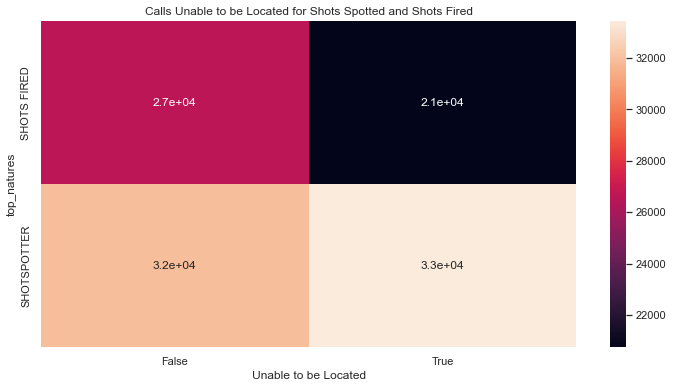

In [74]:
ax = sns.heatmap(data=pd.crosstab(shots_df['top_natures'], shots_df['notLocated']), annot=True)
ax.set_xlabel('Unable to be Located')
ax.set_title('Calls Unable to be Located for Shots Spotted and Shots Fired')
plt.show()

### Performing Statistical Test
The [Chi-Squared test of independance](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html) is used to determine if there is a relationship between two or more variables by determining if they have a similar distribution. The [Chi-Squared test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html#scipy.stats.chisquare) is used to test if one feature has a specific distribution. This means the test of independance will be used.

In [75]:
# combination_counts = original_cleaned_data[["type",target]].groupby(by=["type",target]).size().unstack(level=0).fillna(0)
# chi2, p, _, _ = stats.chi2_contingency(combination_counts)
compared = ['top_natures', 'notLocated']
_, p, _, _ = stats.chi2_contingency(shots_df[compared].groupby(by=compared).size().unstack(level=0).fillna(0))
print('The p-value for the test of independance between nature and notLocated is: %e' % p)

The p-value for the test of independance between nature and notLocated is: 1.193859e-130


### Conclusions for Research Question 2
The Chi-Squared test of independance reported a p-value of approximatly $1.194*10^{-130}$ when comparing the number of unlocated calls for shots fired and shots spotted. The p-value being less than the thrshold of 0.0125 means the comparison was statistically significant. From this we reject the null hypothesis and accept the alternative. This means that there is a relationship between the number of calls for shots fired or shots spotted and the number of unlocated calls. The above chart shows that shots fired had a higher ratio of calls located to unlocated calls. This would meant that more shots fired calls were able to be located than shots spotted calls. This is the opposite of the hypothesis stated at the top of the notebook. Thus we reject our original hypothesis that significantly more shots fired calls are unable to be located than shots spotted.

## Research Question 3: Does the Proportion of Shots Spotted and Shots Fired Correlate With Certain Dates Including Holidays and Events?
The following holdays will be used in this comparison:
- Independance day: July 4th, any year
- Christmas: December 25th, any year
- New Years Eve: December 31st, any year
- New Years: January 1st, any year
- Valentines Day: February 14th, any year
- Halloween: October 31st, any year
- Saint Patrick's Day: March 17th, any year

Thanksgiving will not be compared because it occurs on different days each year. Black friday will not be compared for the same reason. Due to the nature of this question it will likely be easiest to examine this question on a monthly basis instead of on a yearly basis.

### Graphs

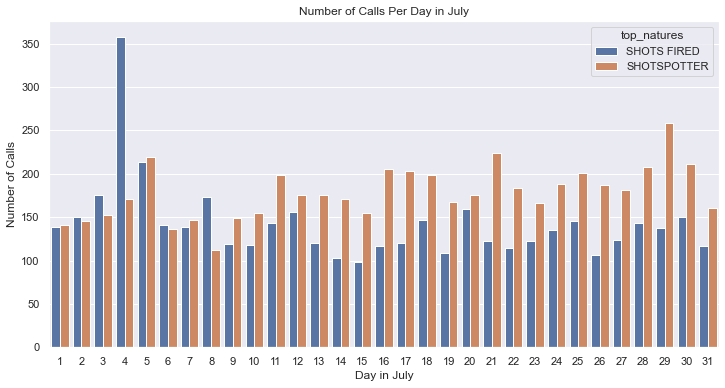

In [76]:
ax = sns.countplot(x="day", hue='top_natures', data=shots_df[shots_df['month'] == 7]) # 7 denotes the month of July
# ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax.set_xlabel('Day in July')
ax.set_ylabel('Number of Calls')
ax.set_title('Number of Calls Per Day in July')
plt.show()

This graph shows that there are a lot more calls for shots fired than normal on the fourth of July. This is likely due to people mistaking the sounds of fireworks in the distance for gunshots. This is likely reinforced by the shotspotter calls remaining much lower.

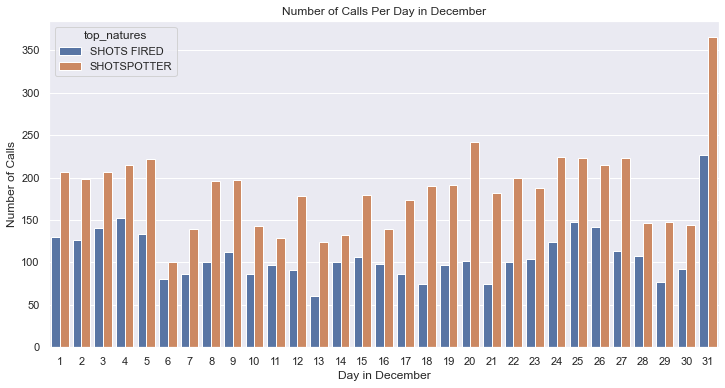

In [77]:
ax = sns.countplot(x="day", hue='top_natures', data=shots_df[shots_df['month'] == 12]) # 12 denotes the month of December
# ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax.set_xlabel('Day in December')
ax.set_ylabel('Number of Calls')
ax.set_title('Number of Calls Per Day in December')
plt.show()

This graph shows that there is a large spike in shots fired and shots spotted on new years eve. It also shows that there may be a slight increase around Christmas. The slight increase around christmas may not be significant though.

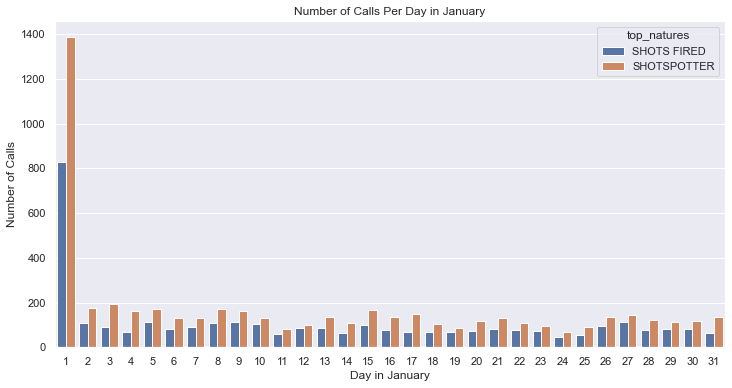

In [78]:
ax = sns.countplot(x="day", hue='top_natures', data=shots_df[shots_df['month'] == 1]) # 1 denotes the month of January
# ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax.set_xlabel('Day in January')
ax.set_ylabel('Number of Calls')
ax.set_title('Number of Calls Per Day in January')
plt.show()

This graph shows that there is a massive increase in calls for shots spotted and shots fired on new years day. There are more than four times as many calls on the first compared to other days of the month.

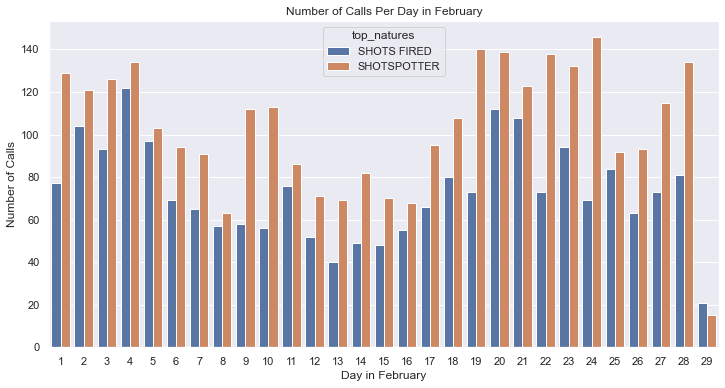

In [79]:
ax = sns.countplot(x="day", hue='top_natures', data=shots_df[shots_df['month'] == 2]) # 2 denotes the month of February
# ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax.set_xlabel('Day in February')
ax.set_ylabel('Number of Calls')
ax.set_title('Number of Calls Per Day in February')
plt.show()

This graph shows that there may actually be a decrease in calls around valentines day compared to the rest of the month.

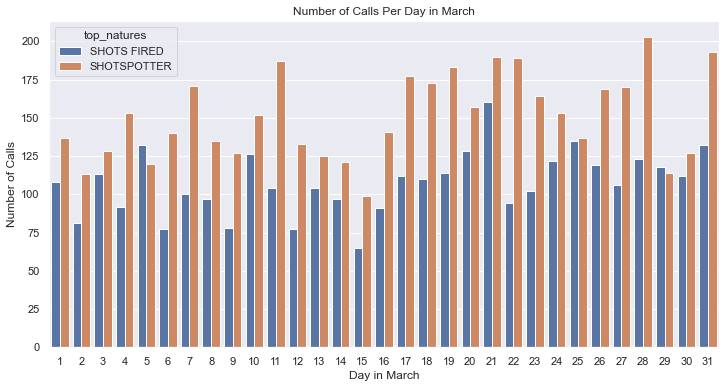

In [80]:
ax = sns.countplot(x="day", hue='top_natures', data=shots_df[shots_df['month'] == 3]) # 3 denotes the month of March
# ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax.set_xlabel('Day in March')
ax.set_ylabel('Number of Calls')
ax.set_title('Number of Calls Per Day in March')
plt.show()

This graph is very jumpy which makes it hard to draw any conclusions from the graph alone. It does seem that there is not a significant difference for Saint Patrick's Day compared to other days.

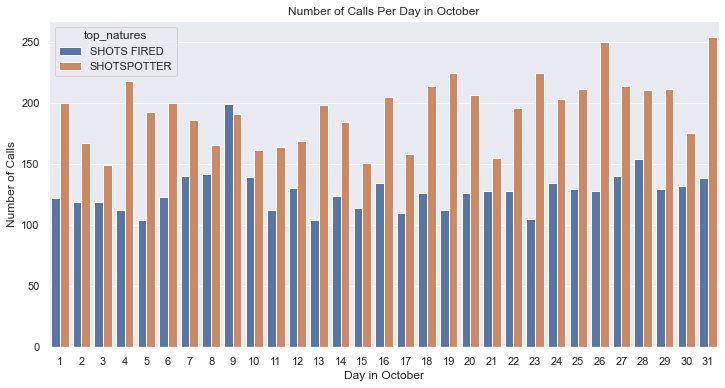

In [81]:
ax = sns.countplot(x="day", hue='top_natures', data=shots_df[shots_df['month'] == 10]) # 10 denotes the month of October
# ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax.set_xlabel('Day in October')
ax.set_ylabel('Number of Calls')
ax.set_title('Number of Calls Per Day in October')
plt.show()

This graph does not seem to show a large increase in shots spotted or shots fired on Halloween.

#### Looking Closer at New Years Eve and New Years Day

C:\Users\fassg\AppData\Local\Temp/ipykernel_137320/758431015.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax = sns.countplot(x="hour", hue='top_natures', data=shots_df[shots_df['month'] == 12][shots_df['day']==31]) # 1 denotes the month of January


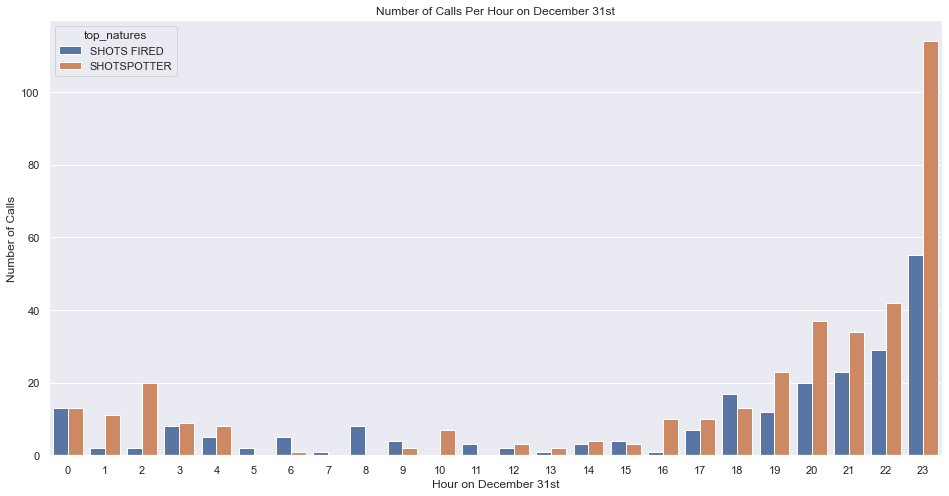

In [203]:
ax = sns.countplot(x="hour", hue='top_natures', data=shots_df[shots_df['month'] == 12][shots_df['day']==31]) # 1 denotes the month of January
# ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax.set_xlabel('Hour on December 31st')
ax.set_ylabel('Number of Calls')
ax.set_title('Number of Calls Per Hour on December 31st')
plt.show()

C:\Users\fassg\AppData\Local\Temp/ipykernel_137320/3550930659.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax = sns.countplot(x="hour", hue='top_natures', data=shots_df[shots_df['month'] == 1][shots_df['day']==1]) # 1 denotes the month of January


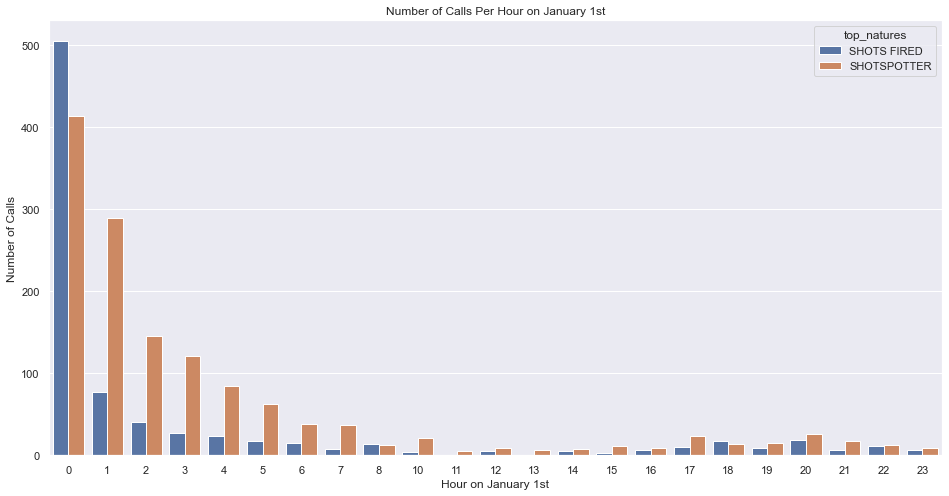

In [204]:
ax = sns.countplot(x="hour", hue='top_natures', data=shots_df[shots_df['month'] == 1][shots_df['day']==1]) # 1 denotes the month of January
# ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax.set_xlabel('Hour on January 1st')
ax.set_ylabel('Number of Calls')
ax.set_title('Number of Calls Per Hour on January 1st')
plt.show()

### Statistical Tests
This section will perform statistical tests to see if a measured distribution (shown by the above graphs) matches the expected baseline that all days are equal. This will be done using the [chi-squared goodness of fit test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html) which automatically generates the baseline to compare against. Two tests will be run per graph shown above. One test will be performed for the given distribution of shots fired, and one test for shots spotted. The null hypothesis for the goodness of fit test is that the data has the given frequencies. In other words, the null hypothesis is that the measured distribution matches the baseline.

#### Statistical Tests for July

In [161]:
# Extract distributions to use in statistical tests
all_calls_in_target_month = shots_df[shots_df['month'] == 7]
shots_fired_in_target_month = all_calls_in_target_month[all_calls_in_target_month['top_natures']=='SHOTS FIRED']
shots_spotted_in_target_month = all_calls_in_target_month[all_calls_in_target_month['top_natures']=='SHOTSPOTTER']
shots_fired_day_counts = shots_fired_in_target_month['day'].value_counts().sort_index()
shots_spotted_day_counts = shots_spotted_in_target_month['day'].value_counts().sort_index()

In [162]:
_, p = chisquare(shots_fired_day_counts)
print('The p-value for the goodness of fit test between the measured and baseline counts for shots fired per day in July is: %e' % p)

The p-value for the goodness of fit test between the measured and baseline counts for shots fired per day in July is: 1.140423e-78


In [163]:
_, p = chisquare(shots_spotted_day_counts)
print('The p-value for the goodness of fit test between the measured and baseline counts for shots spotted per day in July is: %e' % p)

The p-value for the goodness of fit test between the measured and baseline counts for shots spotted per day in July is: 3.341114e-19


The Chi-Squared goodness of fit test reported a p-value of approximatly $1.140*10^{-78}$ for shots fired and approximatly $3.341*10^{-19}$ for shots spotted. The shots fired p-value being less than the threshold of $2.441*10^{-5}$ means the test was statisticaly significant. From this we reject the null hypothesis and accept the alternative. This means the distribution of number of shots fired per day does not match the expected baseline. The shots spotted p-value being less than the threshold of $1.221*10^{-5}$ means the test was statistically significant. From this we reject the null hypothesis and accept the alternative. This means the distribution of number of shots spotted per day does not match the expected baseline.

#### Statistical Tests for December

In [146]:
# Extract distributions to use in statistical tests
all_calls_in_target_month = shots_df[shots_df['month'] == 12]
shots_fired_in_target_month = all_calls_in_target_month[all_calls_in_target_month['top_natures']=='SHOTS FIRED']
shots_spotted_in_target_month = all_calls_in_target_month[all_calls_in_target_month['top_natures']=='SHOTSPOTTER']
shots_fired_day_counts = shots_fired_in_target_month['day'].value_counts().sort_index()
shots_spotted_day_counts = shots_spotted_in_target_month['day'].value_counts().sort_index()

In [147]:
_, p = chisquare(shots_fired_day_counts)
print('The p-value for the goodness of fit test between the measured and baseline counts for shots fired per day in December is: %e' % p)

The p-value for the goodness of fit test between the measured and baseline counts for shots fired per day in December is: 1.370534e-42


In [148]:
_, p = chisquare(shots_spotted_day_counts)
print('The p-value for the goodness of fit test between the measured and baseline counts for shots spotted per day in December is: %e' % p)

The p-value for the goodness of fit test between the measured and baseline counts for shots spotted per day in December is: 9.063287e-65


The Chi-Squared goodness of fit test reported a p-value of approximatly $1.370*10^{-42}$ for shots fired and approximatly $9.063*10^{-65}$ for shots spotted. The shots fired p-value being less than the threshold of $6.250*10^{-3}$ means the test was statisticaly significant. From this we reject the null hypothesis and accept the alternative. This means the distribution of number of shots fired per day does not match the expected baseline. The shots spotted p-value being less than the threshold of $3.125*10^{-3}$ means the test was statistically significant. From this we reject the null hypothesis and accept the alternative. This means the distribution of number of shots spotted per day does not match the expected baseline.

#### Statistical Tests for January

In [149]:
# Extract distributions to use in statistical tests
all_calls_in_target_month = shots_df[shots_df['month'] == 1]
shots_fired_in_target_month = all_calls_in_target_month[all_calls_in_target_month['top_natures']=='SHOTS FIRED']
shots_spotted_in_target_month = all_calls_in_target_month[all_calls_in_target_month['top_natures']=='SHOTSPOTTER']
shots_fired_day_counts = shots_fired_in_target_month['day'].value_counts().sort_index()
shots_spotted_day_counts = shots_spotted_in_target_month['day'].value_counts().sort_index()

In [150]:
_, p = chisquare(shots_fired_day_counts)
print('The p-value for the goodness of fit test between the measured and baseline counts for shots fired per day in January is: %e' % p)

The p-value for the goodness of fit test between the measured and baseline counts for shots fired per day in January is: 0.000000e+00


In [151]:
_, p = chisquare(shots_spotted_day_counts)
print('The p-value for the goodness of fit test between the measured and baseline counts for shots spotted per day in January is: %e' % p)

The p-value for the goodness of fit test between the measured and baseline counts for shots spotted per day in January is: 0.000000e+00


The Chi-Squared goodness of fit test reported a p-value of approximatly $0.000*10^{0}$ for shots fired and approximatly $0.000*10^{0}$ for shots spotted. The shots fired p-value being less than the threshold of $1.563*10^{-3}$ means the test was statisticaly significant. From this we reject the null hypothesis and accept the alternative. This means the distribution of number of shots fired per day does not match the expected baseline. The shots spotted p-value being less than the threshold of $7.813*10^{-4}$ means the test was statistically significant. From this we reject the null hypothesis and accept the alternative. This means the distribution of number of shots spotted per day does not match the expected baseline.

#### Statistical Tests for February

In [152]:
# Extract distributions to use in statistical tests
all_calls_in_target_month = shots_df[shots_df['month'] == 2]
shots_fired_in_target_month = all_calls_in_target_month[all_calls_in_target_month['top_natures']=='SHOTS FIRED']
shots_spotted_in_target_month = all_calls_in_target_month[all_calls_in_target_month['top_natures']=='SHOTSPOTTER']
shots_fired_day_counts = shots_fired_in_target_month['day'].value_counts().sort_index()
shots_spotted_day_counts = shots_spotted_in_target_month['day'].value_counts().sort_index()

In [153]:
_, p = chisquare(shots_fired_day_counts)
print('The p-value for the goodness of fit test between the measured and baseline counts for shots fired per day in February is: %e' % p)

The p-value for the goodness of fit test between the measured and baseline counts for shots fired per day in February is: 8.120108e-28


In [154]:
_, p = chisquare(shots_spotted_day_counts)
print('The p-value for the goodness of fit test between the measured and baseline counts for shots spotted per day in February is: %e' % p)

The p-value for the goodness of fit test between the measured and baseline counts for shots spotted per day in February is: 1.900191e-37


#### Statistical Tests for October

In [155]:
# Extract distributions to use in statistical tests
all_calls_in_target_month = shots_df[shots_df['month'] == 10]
shots_fired_in_target_month = all_calls_in_target_month[all_calls_in_target_month['top_natures']=='SHOTS FIRED']
shots_spotted_in_target_month = all_calls_in_target_month[all_calls_in_target_month['top_natures']=='SHOTSPOTTER']
shots_fired_day_counts = shots_fired_in_target_month['day'].value_counts().sort_index()
shots_spotted_day_counts = shots_spotted_in_target_month['day'].value_counts().sort_index()

In [156]:
_, p = chisquare(shots_fired_day_counts)
print('The p-value for the goodness of fit test between the measured and baseline counts for shots fired per day in October is: %e' % p)

The p-value for the goodness of fit test between the measured and baseline counts for shots fired per day in October is: 6.792121e-06


In [157]:
_, p = chisquare(shots_spotted_day_counts)
print('The p-value for the goodness of fit test between the measured and baseline counts for shots spotted per day in October is: %e' % p)

The p-value for the goodness of fit test between the measured and baseline counts for shots spotted per day in October is: 3.708554e-12


The Chi-Squared goodness of fit test reported a p-value of approximatly $6.792*10^{-6}$ for shots fired and approximatly $3.709*10^{-12}$ for shots spotted. The shots fired p-value being less than the threshold of $3.906*10^{-4}$ means the test was statisticaly significant. From this we reject the null hypothesis and accept the alternative. This means the distribution of number of shots fired per day does not match the expected baseline. The shots spotted p-value being less than the threshold of $1.953*10^{-4}$ means the test was statistically significant. From this we reject the null hypothesis and accept the alternative. This means the distribution of number of shots spotted per day does not match the expected baseline.

#### Statistical Tests for March

In [158]:
# Extract distributions to use in statistical tests
all_calls_in_target_month = shots_df[shots_df['month'] == 3]
shots_fired_in_target_month = all_calls_in_target_month[all_calls_in_target_month['top_natures']=='SHOTS FIRED']
shots_spotted_in_target_month = all_calls_in_target_month[all_calls_in_target_month['top_natures']=='SHOTSPOTTER']
shots_fired_day_counts = shots_fired_in_target_month['day'].value_counts().sort_index()
shots_spotted_day_counts = shots_spotted_in_target_month['day'].value_counts().sort_index()

In [159]:
_, p = chisquare(shots_fired_day_counts)
print('The p-value for the goodness of fit test between the measured and baseline counts for shots fired per day in March is: %e' % p)

The p-value for the goodness of fit test between the measured and baseline counts for shots fired per day in March is: 3.336427e-12


In [160]:
_, p = chisquare(shots_spotted_day_counts)
print('The p-value for the goodness of fit test between the measured and baseline counts for shots spotted per day in March is: %e' % p)

The p-value for the goodness of fit test between the measured and baseline counts for shots spotted per day in March is: 1.778199e-18


The Chi-Squared goodness of fit test reported a p-value of approximatly $3.336*10^{-12}$ for shots fired and approximatly $1.778*10^{-18}$ for shots spotted. The shots fired p-value being less than the threshold of $9.766*10^{-5}$ means the test was statisticaly significant. From this we reject the null hypothesis and accept the alternative. This means the distribution of number of shots fired per day does not match the expected baseline. The shots spotted p-value being less than the threshold of $4.883*10^{-5}$ means the test was statistically significant. From this we reject the null hypothesis and accept the alternative. This means the distribution of number of shots spotted per day does not match the expected baseline.

### Conclusions for Research Question 3
Every test returned a p-value below the specified threshold. This means that all of the tests for both shots fired and shots spotted were significant. This means we reject the null hypothesis and accept the alternative in each of the above cases. The number of shots fired and shots spotted is correlated with day of the month for July, December, January, February, October, and March.

## Research Question 4: Does the Number of Calls Correlate With Certain Weather Conditions?

### Compare Number of Calls With Weather Description

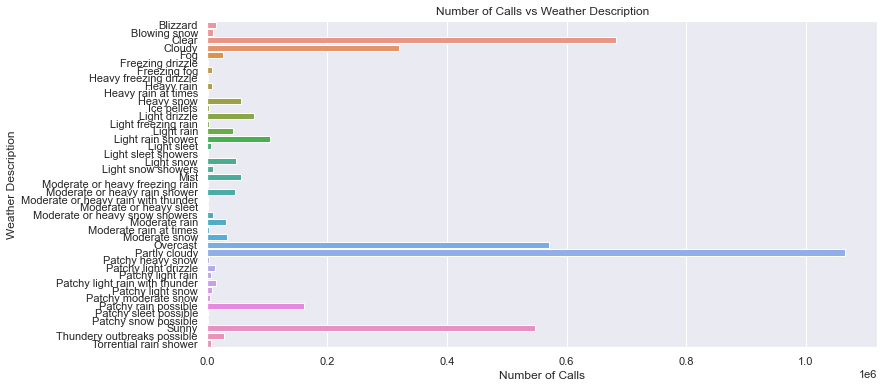

In [82]:
ax = sns.countplot(y="weatherDesc", data=df)
# ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax.set_xlabel('Number of Calls')
ax.set_ylabel('Weather Description')
ax.set_title('Number of Calls vs Weather Description')
plt.show()

The above graph shows that there are much more calls for some types of weather than others. The most calls occur when it is partially cloudy. This could just be due there being more occurances of these weather types than the other types. Therefore no conclusions can be drawn from this graph in particular. To make the graph more accurate, the number of calls for each weather type should be divided by the number of days with that weather type.

In [173]:
weather_type = []
counts = []
for weather in df['weatherDesc'].unique():
    day_count_of_weather = len(df[df['weatherDesc'] == weather]['date'].unique())
    total_occurances_of_weather_type = df[df['weatherDesc'] == weather].shape[0]
    weather_type.append(weather)
    counts.append((total_occurances_of_weather_type / day_count_of_weather))
# weather_per_day = pd.Series(counts, index=weather_type)

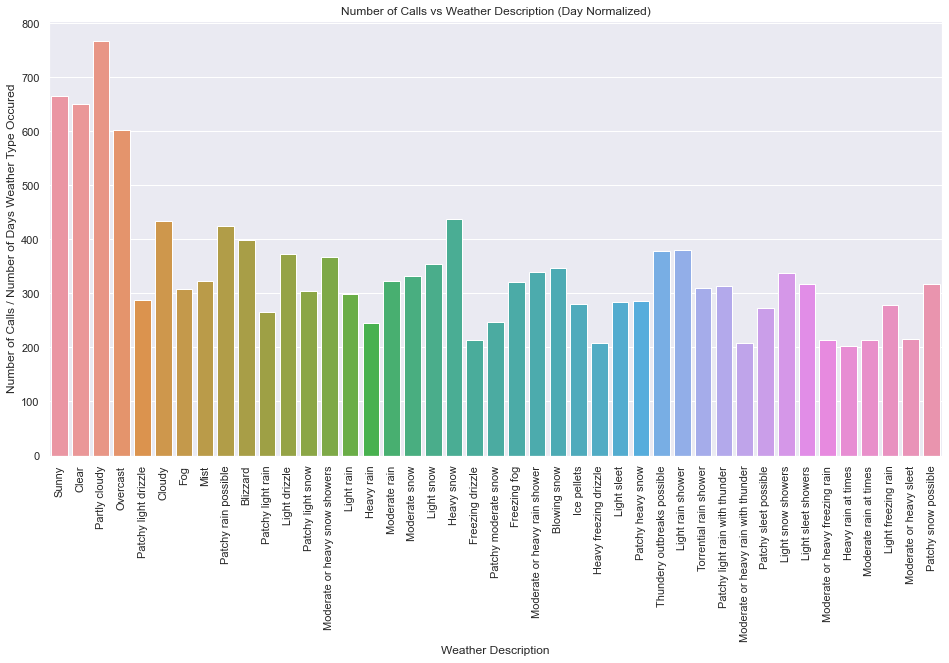

In [174]:
ax = sns.barplot(y=counts, x=weather_type)
ax.set_ylabel('Number of Calls / Number of Days Weather Type Occured')
ax.set_xlabel('Weather Description')
ax.set_title('Number of Calls vs Weather Description (Day Normalized)')
plt.xticks(rotation = 90)
plt.show()

The above graph now shows the number of calls for each weather type divided by the number of days each of those weather types occured. It appears like there are more calls when it is sunny, clear, partly cloudy, or overcast than during other weather conditions.


### Compare Number of Calls With Weather Temperature

In [169]:
temps = []
temp_counts = []
for temp in df['FeelsLikeC'].unique():
    day_count_of_weather = len(df[df['FeelsLikeC'] == temp]['date'].unique())
    total_occurances_of_weather_temp = df[df['FeelsLikeC'] == temp].shape[0]
    temps.append(temp)
    temp_counts.append((total_occurances_of_weather_temp / day_count_of_weather))

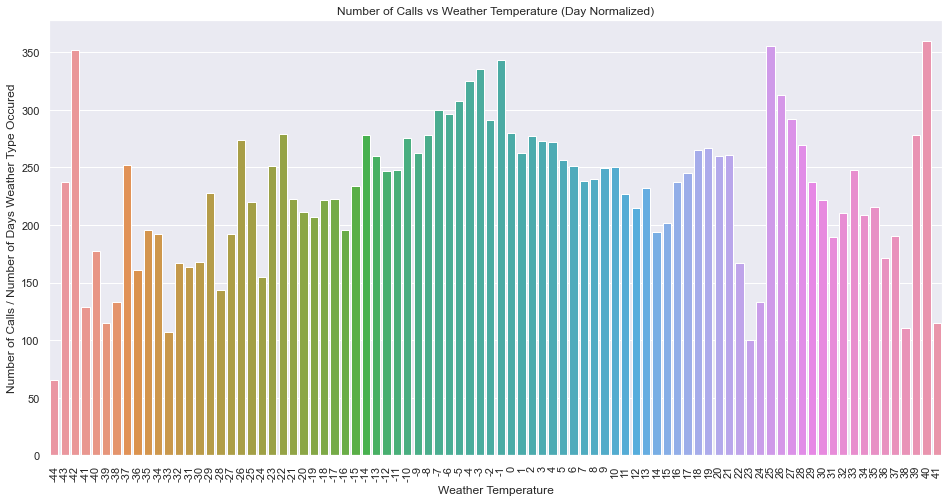

In [170]:
ax = sns.barplot(y=temp_counts, x=temps)
ax.set_ylabel('Number of Calls / Number of Days Weather Type Occured')
ax.set_xlabel('Weather Temperature')
ax.set_title('Number of Calls vs Weather Temperature (Day Normalized)')
plt.xticks(rotation = 90)
plt.show()

In [188]:
# Code to show the baseline distribution
# m = mean(temp_counts)
# mm = list(map(lambda x: m, temp_counts))
# ax = sns.barplot(y=mm, x=temps)
# ax.set_ylabel('Number of Calls / Number of Days Weather Type Occured')
# ax.set_xlabel('Weather Temperature')
# ax.set_title('Number of Calls vs Weather Temperature (Day Normalized)')
# plt.xticks(rotation = 90)
# plt.show()


### Statistical Tests
The statistical test here will be to check to see if the distribution matches some baseline. The baseline in this case would be that all weather types have the same number of calls. This could be restated as weather does not impact the number of calls. The baseline distribution will then be compared to the measured distribution with a chi-squared goodness of fit test. This baseline does not need to be recomputed each time as the baseline is automatically computed by the scipy [chi-squared goodness of fit test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html).

Two statistical tests will be run. One test will be run for the weather description distribution and one for the weather temperature distribution.

In [175]:
_, p = chisquare(counts)
print('The p-value for the goodness of fit test between the measured and baseline counts for weather description is: %e' % p)

The p-value for the goodness of fit test between the measured and baseline counts for weather description is: 0.000000e+00


In [176]:
_, p = chisquare(temp_counts)
print('The p-value for the goodness of fit test between the measured and baseline counts for weather temperature is: %e' % p)

The p-value for the goodness of fit test between the measured and baseline counts for weather temperature is: 2.009600e-242


### Conclusions for Research Question 4
The Chi-Squared goodness of fit test reported a p-value of $0.000*10^{0}$ for the counts of weather description. The weather description p-value being less than the threshold of $6.104*10^{-6}$ means the test was statisticaly significant. From this we reject the null hypothesis and accept the alternative. This means the distribution of number calls per weather type does not match the expected baseline. 

The Chi-Squared goodness of fit test reported a p-value of $2.010*10^{-242}$ for the counts of weather temperature. The weather temperature p-value being less than the threshold of $3.052*10^{-6}$ means the test was statisticaly significant. From this we reject the null hypothesis and accept the alternative. This means the distribution of number calls per weather temperature does not match the expected baseline. 

From this we conclude that the type of weather and the temperature of weather is correlated with number of calls.

# Building Models to Test if Prediction is Possible
This section will attempt to predict the nature of a call by using a logistic regression model and a random forest model. These two models will then be compared. More models were orginally planned to be compared. Unfortunatly, many of the other models took too long to train to be seen as feasable for this project. This is the same reason that a grid search was not run over parameter space to attempt to find the best model.

This section seeks to train models to answer the following research question:
- Is it possible to predict the nature of a call based on its location and district?

## List all of the categorical features and numerical features

In [83]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4027695 entries, 0 to 4027694
Data columns (total 34 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   status                 4027695 non-null  category      
 1   call_id                4027695 non-null  int64         
 2   datetime               4027695 non-null  datetime64[ns]
 3   isCorner               4027695 non-null  bool          
 4   primaryStreetName      4016778 non-null  category      
 5   primaryStreetSuffix    4027695 non-null  category      
 6   secondaryStreetName    4027391 non-null  category      
 7   secondaryStreetSuffix  4027695 non-null  category      
 8   shots_nature           4027695 non-null  category      
 9   top_natures            4027695 non-null  category      
 10  top_districts          4027695 non-null  category      
 11  isdaytime              4027695 non-null  bool          
 12  tempC                  40276

In [84]:
response_name = 'top_natures'

features = df.copy(deep=True)

response = df[response_name]

# https://stackoverflow.com/questions/16453644/regression-with-date-variable-using-scikit-learn
# drop date and datetime but keep the separated ones.
to_drop = ['date', 'datetime', 'weekday', 'shots_nature', 'isdaytime', response_name]

numeric_features = ['call_id', 'tempC', 'windspeedKmph', \
    'winddirdegree', 'precipMM', 'humidity', 'visibilityKm', 'pressureMB',\
        'cloudcover', 'HeatIndexC', 'DewPointC', 'WindChillC', 'WindGustKmph',\
            'FeelsLikeC', 'uvIndex', 'year', 'month', 'week', 'day', 'hour']

categorical_features = ['status', 'primaryStreetName', 'isCorner', \
    'primaryStreetSuffix', 'secondaryStreetName', 'secondaryStreetSuffix', 'top_districts']

features = features.drop(columns=to_drop)

## Create Training and Testing Sets.
The training and testing set sizes will be reduced since the overall number of data points exceedes four million.

In [85]:
train, test = train_test_split(df, test_size=0.005, train_size=0.1, stratify=df[response_name], random_state=42)

In [86]:
x_train = train.drop(columns=to_drop, axis=1)
x_test = test.drop(columns=to_drop, axis=1)
y_train =train[response_name]
y_test = test[response_name]

## Create the Preprocessor Pipeline for Numeric and Categorical Features. 
The preprocessor pipeline will then be combined to form the actual model pipeline.
This code comes from an in class example on the scat pipeline notebook presented during week 9.

In [87]:
numeric_transformer = Pipeline(
    steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [88]:
pipe_lr_svd = Pipeline([("preprocessor", preprocessor),
			('tSVD', TruncatedSVD(n_components=10)),
			('clf', LogisticRegression(random_state=42, solver='liblinear'))])

pipe_rf_svd = Pipeline([("preprocessor", preprocessor),
			('tSVD', TruncatedSVD(n_components=10)),
			('clf', RandomForestClassifier(random_state=42, n_jobs=-1))])

## Test the Different Models
### Estimator: Logistic Regression w/tSVD

In [89]:
print('Estimator: Logistic Regression w/tSVD')
pipe_lr_svd.fit(x_train, y_train)
lr_pred = pipe_lr_svd.predict(x_test)

Estimator: Logistic Regression w/tSVD


In [90]:
accuracy = accuracy_score(y_test, lr_pred)
precision = precision_score(y_test, lr_pred, average='weighted')
recall = recall_score(y_test, lr_pred, average='weighted')
print('Logistic Regression w/tSVD Accuracy = %.3f, Precision = %.3f, Recall = %.3f' % (accuracy, precision, recall))

Logistic Regression w/tSVD Accuracy = 0.300, Precision = 0.108, Recall = 0.300


C:\tools\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


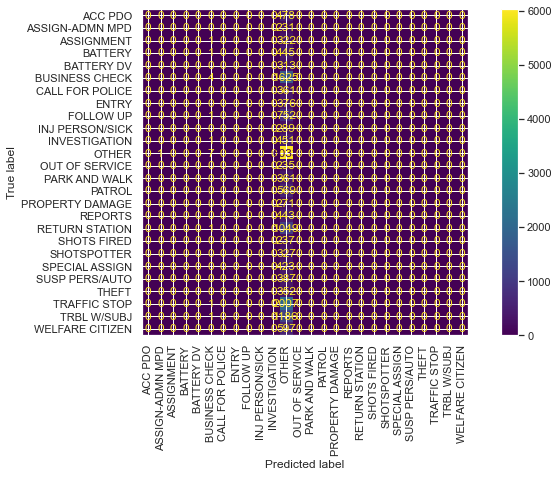

In [91]:
cm = confusion_matrix(y_test, lr_pred, labels=pipe_lr_svd.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_lr_svd.classes_)
disp.plot()
plt.xticks(rotation = 90)
plt.show()

### Estimator: Random Forest w/tSVD

In [92]:
print('Estimator: Random Forest w/tSVD')
pipe_rf_svd.fit(x_train, y_train)
rf_pred = pipe_rf_svd.predict(x_test)

Estimator: Random Forest w/tSVD


In [93]:
accuracy = accuracy_score(y_test, rf_pred)
precision = precision_score(y_test, rf_pred, average='weighted')
recall = recall_score(y_test, rf_pred, average='weighted')
print('Random Forest w/tSVD Accuracy = %.3f, Precision = %.3f, Recall = %.3f' % (accuracy, precision, recall))

Random Forest w/tSVD Accuracy = 0.255, Precision = 0.195, Recall = 0.255


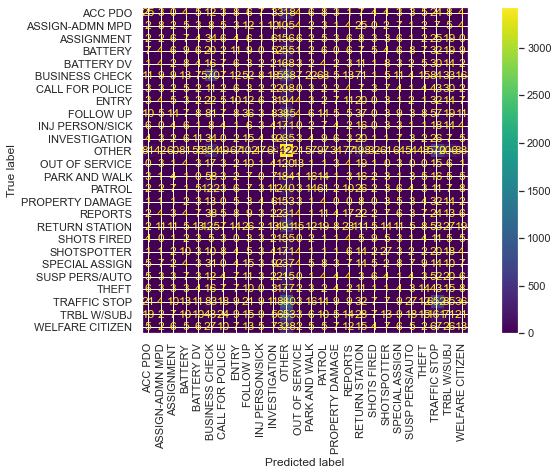

In [94]:
cm = confusion_matrix(y_test, rf_pred, labels=pipe_rf_svd.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_rf_svd.classes_)
disp.plot()
plt.xticks(rotation = 90)
plt.show()

## Evaluating the Models
Neither the random forest model or the logistic regression model performed well when trying to predict the nature of a call on the dataset. The logistic regression model reported a higher accuracy but a lower precision when compared to the random forest model. The confusion matrix for the logistic regression model shows that the difference in the accuracy and precision values is due to the model returning 'OTHER' for all inputs. This means that the model is not a good indicator. The confusion matrix for the random forest model was much more diverse. Unfortunatly the model still returned a low accuracy, precision, and recall. This leads to the conclusion that neither of these models can predict the nature of a call based on the other information about that call. This confirms the hypothesis made at the start of this notebook.

# Conclusion
- Analysis of results, further study, improvements

# TODO Other:
- Explanations of all data and graph outputs
